# Grad-cam folder
This notebook implements the grad-cam algorithm presented in the paper [Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf). Grad-Cam provide a useful tool to understand which region of the model are used to make predictions.  
  
The code is an adaptation of the code example from the officiel Keras website: [Grad-CAM class activation visualization](https://keras.io/examples/vision/grad_cam/)  
Author: [fchollet](https://twitter.com/fchollet)  
Update: Colin Pelletier, Joris Monnet and Kilian Raude

In [20]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tqdm import tqdm
import json
import codecs
import sys
from keras.layers import Flatten
from keras.models import Model


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

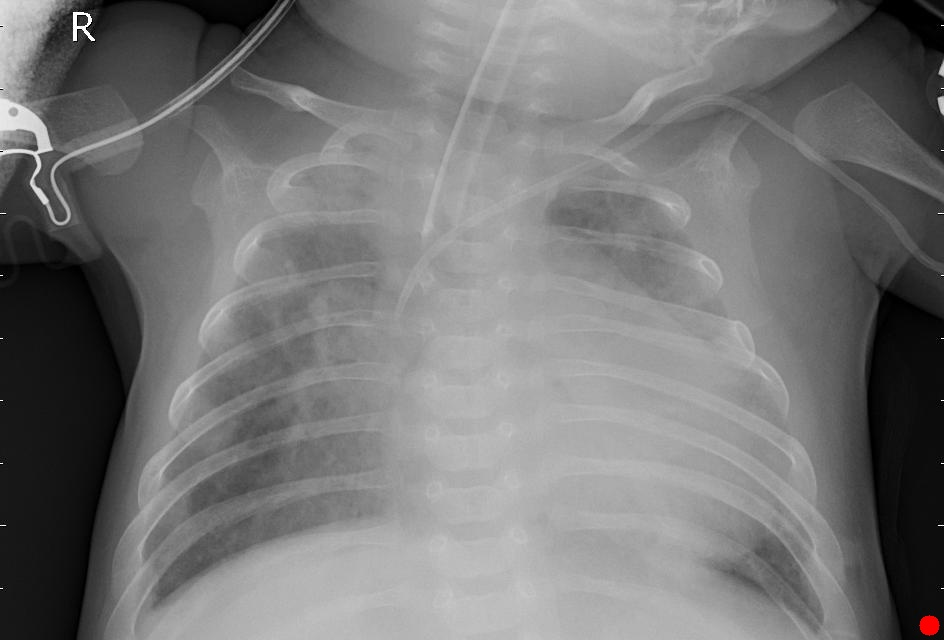

In [19]:
img_size = [180, 180]
img_path = './person1_virus_6.jpeg'
# model_file = './drive/MyDrive/ml-project-2-la_team/generated/dot_model/dot_xray_model.h5'
model_file = './dot_xray_model.h5'
AUTOTUNE = tf.data.experimental.AUTOTUNE

display(Image(img_path))

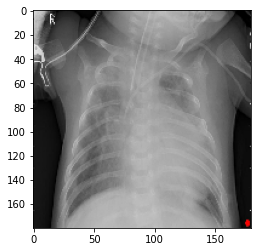

In [18]:
# Prepare image
import pipeline as pip_tools
im_tools = pip_tools.ImageTools(img_size, AUTOTUNE, 'Normal_dot')
img, label = im_tools.process_path(img_path)
img_input = tf.expand_dims(img, axis=0)

plt.imshow(img)

In [21]:
model_file = './drive/MyDrive/ml-project-2-la_team/generated/date_model/dot_xray_model.h5'

# Make model
base_model = keras.models.load_model(model_file)
base_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 sequential_8 (Sequential)   (None, 45, 45, 32)        2160      
                                                                 
 sequential_9 (Sequential)   (None, 22, 22, 64)        7392      
                                                                 
 sequential_10 (Sequential)  (None, 11, 11, 128)       27072     
                                                     

In [13]:
# all layers before flatten are convolutions
gradcam_model = tf.keras.models.Model(
    inputs=[base_model.inputs], 
    outputs=[base_model.layers[8].output, base_model.output]
    )

gradcam_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 sequential_8 (Sequential)   (None, 45, 45, 32)        2160      
                                                                 
 sequential_9 (Sequential)   (None, 22, 22, 64)        7392      
                                                           

In [14]:
# function from the tutorial
def make_gradcam_heatmap(img_array, model, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs], 
        # outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        outputs=[model.layers[-5].output, model.output]
        )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [15]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_input, gradcam_model)

# Display heatmap
plt.matshow(heatmap)
plt.show()

TypeError: ignored

## Create a superimposed visualization

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

## Let's try another image

We will see how the grad cam explains the model's outputs for a multi-label image. Let's
try an image with a cat and a dog together, and see how the grad cam behaves.

In [ ]:
img_path = keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

We generate class activation heatmap for "chow," the class index is 260heatmap for "chow," the class index is 260

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

We generate class activation heatmap for "egyptian cat," the class index is 285

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)